# 📌 End To End Steps¶ 

1️⃣ Load & Explore Data – Import Monthly Tractor Sale dataset, preprocess(box cox), and visualize.


2️⃣ Train-Test Split – Split time series correctly (no shuffling).

3️⃣ Analyze - plot ACF/PACF.

4️⃣ Achieve Stationarity – Apply differencing, ADF test

5️⃣ Baseline Models – Compare with historical mean & last-value models.

6️⃣ Fit SARIMA Model – Select lag order, train AR(p)Id)MA(q)[P,D,Q]

7️⃣ Evaluate Performance – Compare with baselines using MAE

8️⃣ Forecast Future Data – Predict and visualize Next Quarter EPS Data.

# 🔹 Step 1: Import Libraries & Load Data

## Import Data 

In [168]:
import warnings
import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import rcParams
from statsmodels.tsa.seasonal import  STL
import scipy.stats as scs
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [169]:
df = pd.read_csv('data/tractor-sales.csv')

df.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


The dataset consists of 144 observations having the total monthwise sales data of Tractors for a period of past 12 years.

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


## Convert to time series

In [171]:
# rename columns if required
df.rename(columns={'Number of Tractor Sold':'TractorSales', "Month-Year": "Date"}, inplace=True)


In [172]:
# Explicitly specify the format of date
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y') + pd.offsets.MonthBegin(0)


In [173]:
df.head()

,Date,TractorSales
0,2003-01-01,141
1,2003-02-01,157
2,2003-03-01,185
3,2003-04-01,199
4,2003-05-01,203


In [174]:
df['Date'] = pd.to_datetime(df['Date'])

# Set the date as the index
df.set_index('Date', inplace=True)


# Display the dataframe
df.head()

,TractorSales
Date,
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203


In [175]:
df.isna().sum()

TractorSales    0
dtype: int64

# 🔹 Step 2: Data Analysis And Visualization

<Axes: xlabel='Date'>

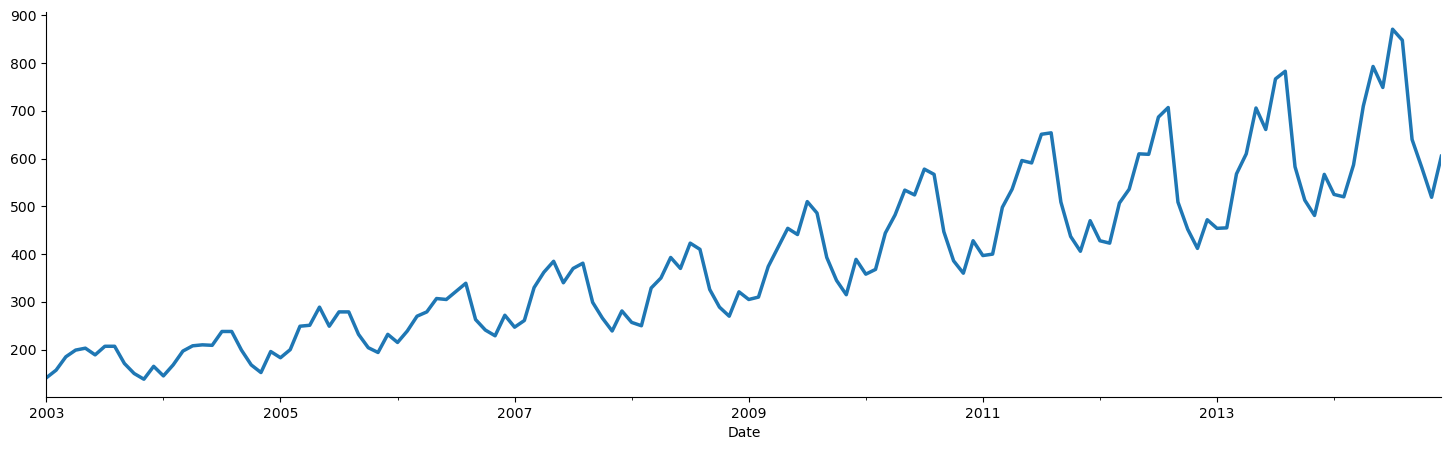

In [176]:
#plot time series
df['TractorSales'].plot()

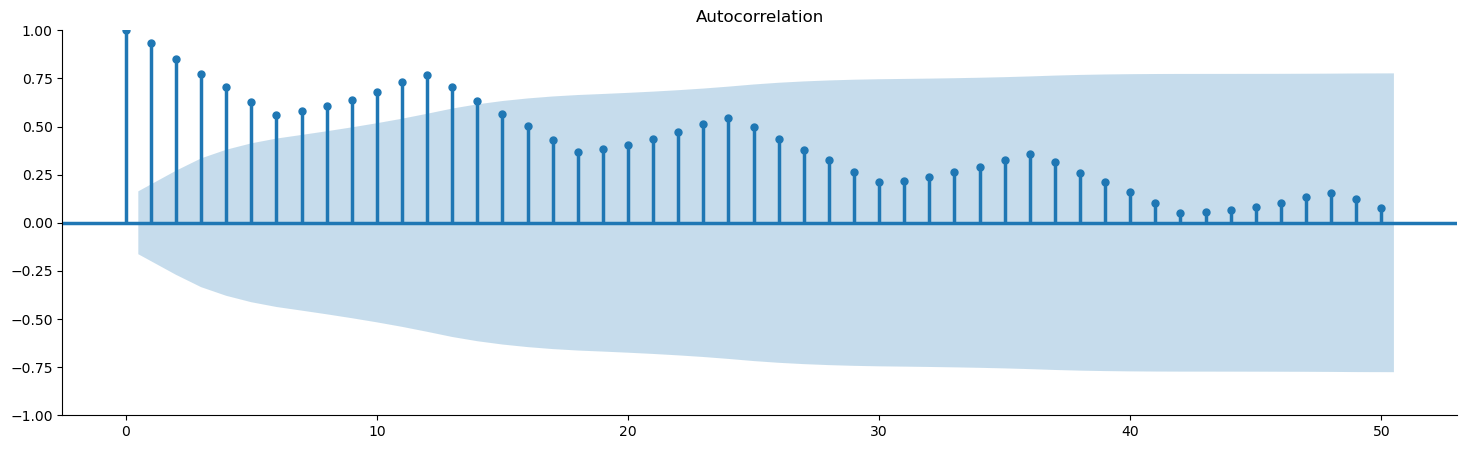

In [177]:
plot_acf(df.TractorSales,lags=50)
plt.show()

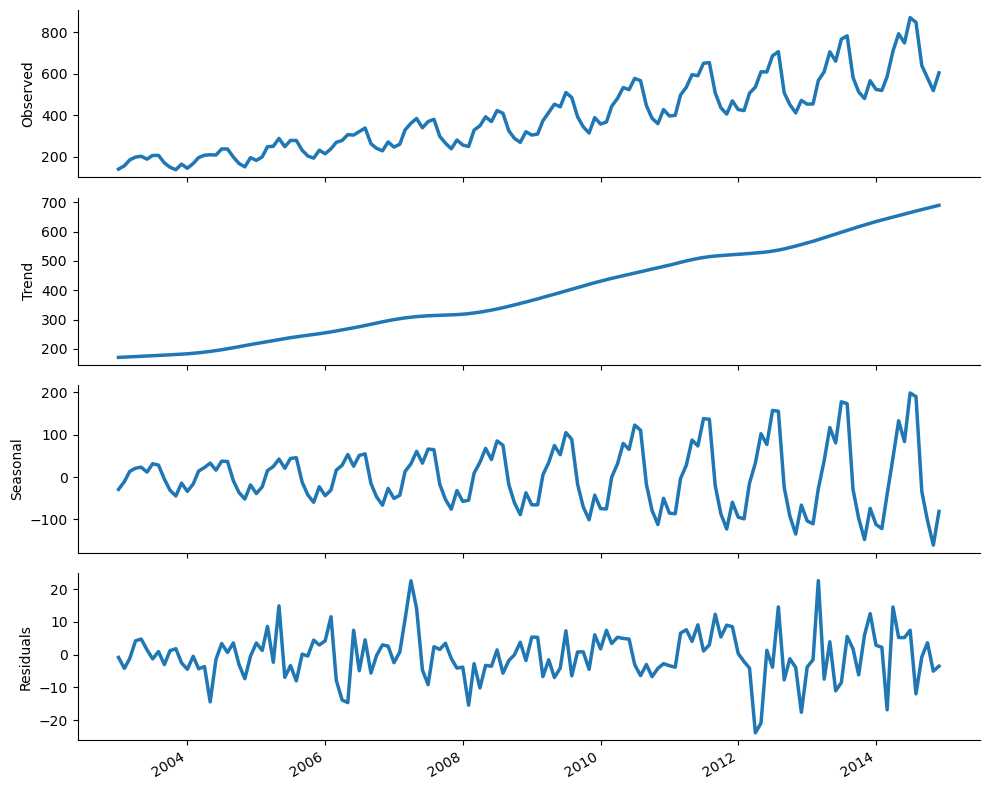

In [178]:
# decompose data to identify underlying structure
decomposition = STL(df.TractorSales, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

# plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()




# Check For Stationarity

## Rolling Statistics

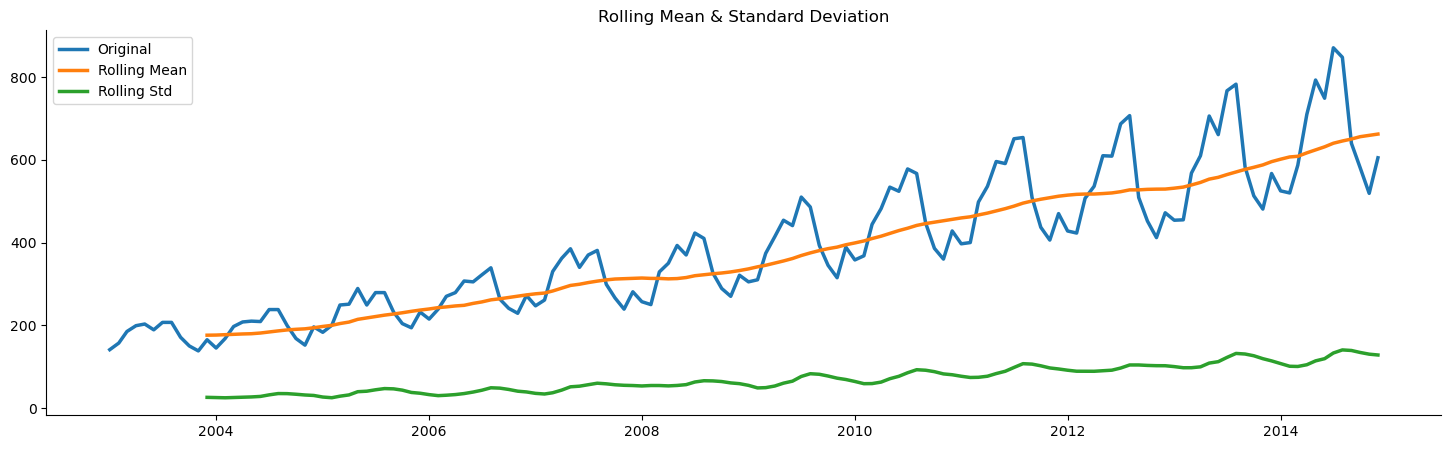

In [179]:
#Determing rolling statistics
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

 The variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series

## ADF Test

In [180]:
# ADF Test
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series, autolag='AIC')

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")


In [181]:
adf_test(df['TractorSales'])


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic   1.108825
               p-value   0.995291
           # Lags Used  14.000000
Number of Observations 129.000000
   Critical Value (1%)  -3.482088
   Critical Value (5%)  -2.884219
  Critical Value (10%)  -2.578864

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.99529 > 0.05)


# SARIMA Model Development

## Elimination of Stationarity 

## Complete SARIMA Preprocessing Steps
1️⃣ Apply Box-Cox transformation to stabilize variance.

2️⃣ Perform ADF test on the transformed series.

3️⃣ Apply seasonal differencing (D) first.

4️⃣ Perform ADF test again.

5️⃣ If still non-stationary, apply trend differencing (d).

6️⃣ Final ADF test to confirm stationarity.

## Elimination of non-constant variance (Heteroscedasticity)

In [182]:
def apply_boxcox(series, plot=True):

    # Apply Box-Cox transformation
    transformed_data, lambda_value = boxcox(series)

    # Convert to pandas Series
    transformed_series = pd.Series(transformed_data, index=series.index)

  
    return transformed_series, lambda_value


In [183]:
# Function to perform inverse Box-Cox transformation
def inverse_boxcox(y, lam):
    return np.power(y * lam + 1, 1 / lam) if lam != 0 else np.exp(y)

In [184]:
# Apply Box-Cox transformation
df_boxcox, lambda_value = apply_boxcox(df['TractorSales'])

# Print the optimal lambda value
print(f"Optimal λ (lambda): {lambda_value:.4f}")

Optimal λ (lambda): 0.1337


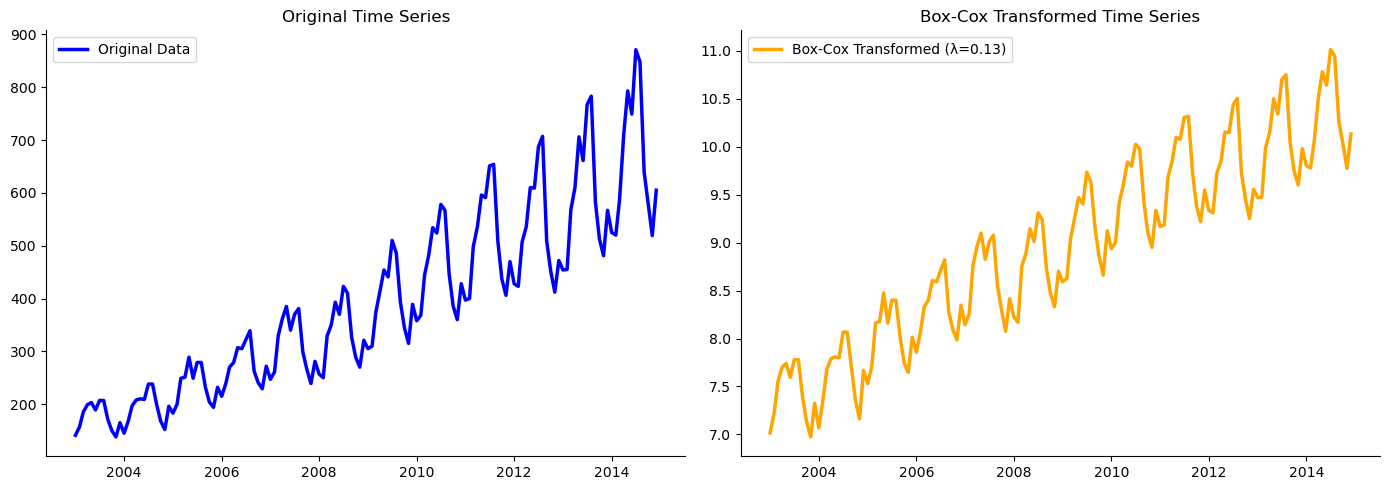

In [185]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df, label='Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Box-Cox transformed series
axes[1].plot(df_boxcox, label=f'Box-Cox Transformed (λ={lambda_value:.2f})', color='orange')
axes[1].set_title('Box-Cox Transformed Time Series')
axes[1].legend()

plt.tight_layout()
plt.show()

## Check for Stationarity of Box Cox Transformed Series


In [186]:
adf_test(df_boxcox)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic  -1.376888
               p-value   0.593305
           # Lags Used  13.000000
Number of Observations 130.000000
   Critical Value (1%)  -3.481682
   Critical Value (5%)  -2.884042
  Critical Value (10%)  -2.578770

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.59330 > 0.05)


## Apply Seasonal Differencing (D) 


In [187]:
# first  order differencing

# Apply differencing to the Box-Cox transformed data (12 periods lag)
df_diff_1 = pd.Series(df_boxcox - df_boxcox.shift(periods=12), index=df.index)

# Drop missing values after differencing
df_diff_1.dropna(inplace=True)

In [188]:
#check with ADF test
adf_test(df_diff_1)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic  -2.847232
               p-value   0.051837
           # Lags Used  12.000000
Number of Observations 119.000000
   Critical Value (1%)  -3.486535
   Critical Value (5%)  -2.886151
  Critical Value (10%)  -2.579896

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.05184 > 0.05)


Seasonal Differencing D=1

##  Elimination non-constant mean with differencing (Trend)

Apply Trend Differencing (d) if needed->
If the seasonally differenced series is still non-stationary, apply first-order differencing.

In [189]:
#Apply second-order differencing to the previously differenced Box-Cox transformed data
df_boxcox_second_order_diff = pd.Series(df_diff_1 - df_diff_1.shift(), index=df.index)

# Drop missing values after second-order differencing
df_boxcox_second_order_diff.dropna(inplace=True)



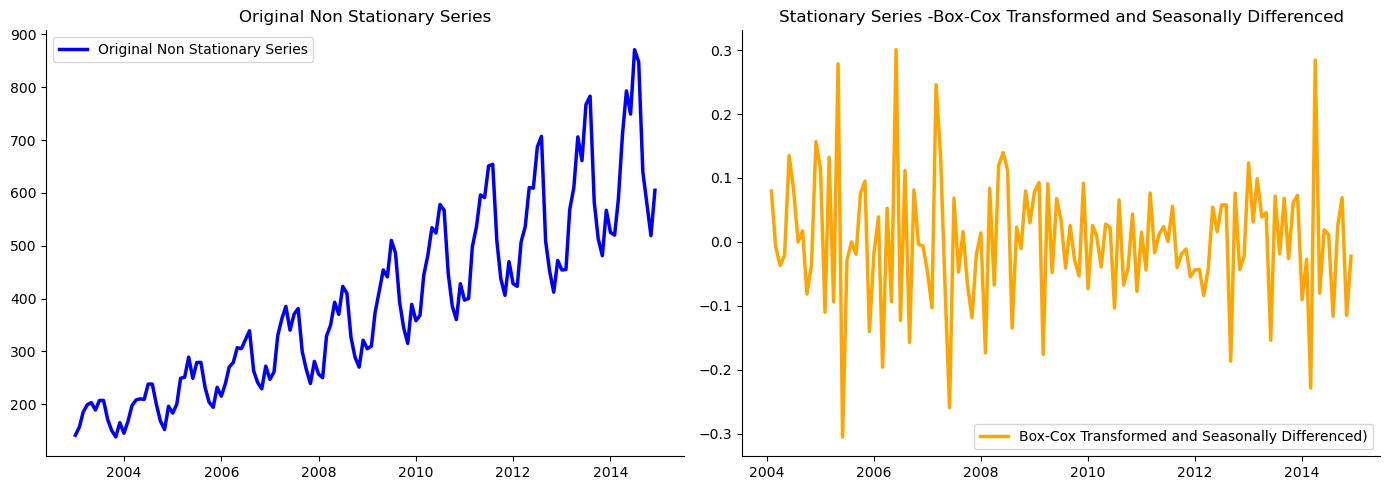

In [190]:
#plot the series to compare 

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df, label='Original Non Stationary Series', color='blue')
axes[0].set_title('Original Non Stationary Series')
axes[0].legend()

# Box-Cox transformed series
axes[1].plot(df_boxcox_second_order_diff, label=f'Box-Cox Transformed and Seasonally Differenced)', color='orange')
axes[1].set_title('Stationary Series -Box-Cox Transformed and Seasonally Differenced')
axes[1].legend()

plt.tight_layout()
plt.show()


In [191]:
adf_test(df_boxcox_second_order_diff)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic  -4.432579
               p-value   0.000260
           # Lags Used  12.000000
Number of Observations 118.000000
   Critical Value (1%)  -3.487022
   Critical Value (5%)  -2.886363
  Critical Value (10%)  -2.580009

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00026 ≤ 0.05)


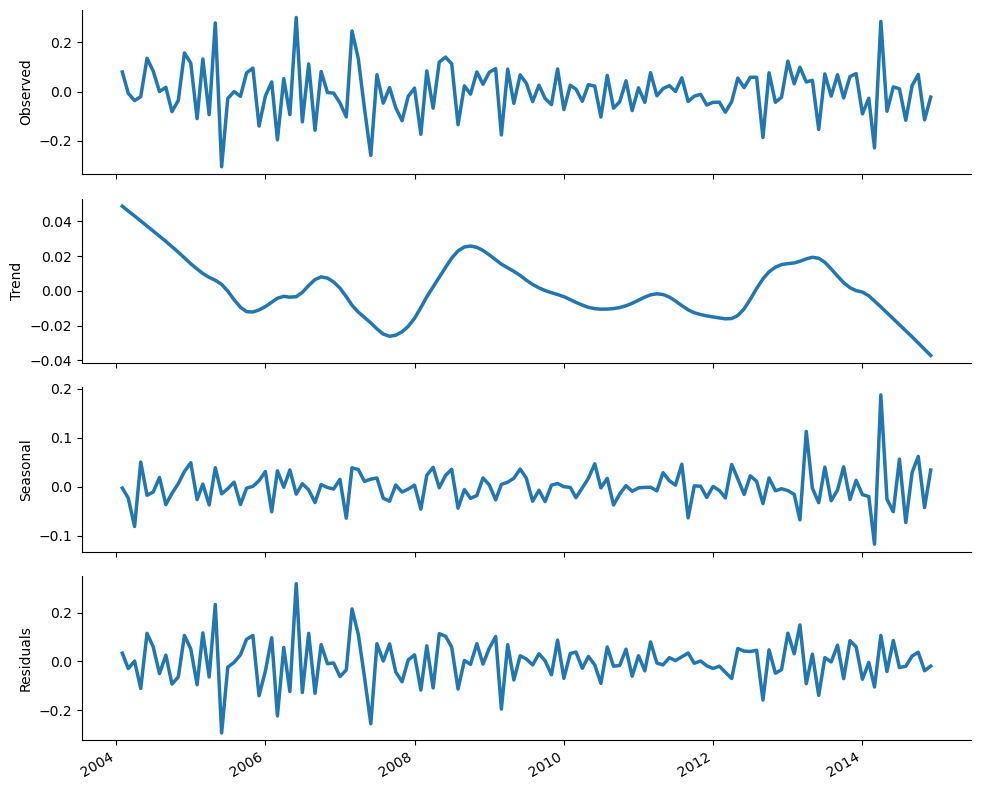

In [192]:
# decompose data to identify underlying structure after removing seasonality
decomposition = STL(df_boxcox_second_order_diff, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

# plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()




# Train Test Split Data

Splitting the time series data (df_diff2) into two parts: a training set and a test set. The training set will be used to build a forecasting model, while the test set is used to evaluate the model's performance on unseen data.

Here the dataset consists of 144 observations having the total monthwise sales data of Tractors for a period of past 12 years.We can split into train data(first 120 recors) of 10 years and test data(last 24 records) of last 2 years


In [193]:
# Calculate the number of training samples (80% of the data length)

num_train = 120

# Split the original data into training and testing sets
train = df[:num_train] 
test = df[num_train:]  

In [194]:
train.head()

,TractorSales
Date,
2003-01-01,141
2003-02-01,157
2003-03-01,185
2003-04-01,199
2003-05-01,203


In [195]:
test.tail()

,TractorSales
Date,
2014-08-01,848
2014-09-01,640
2014-10-01,581
2014-11-01,519
2014-12-01,605


In [196]:
# Split the transformed Box-Cox and differenced data into training and testing sets
train_data = df_boxcox[:num_train]  
test_data = df_boxcox[num_train:] 
     

In [197]:
train_data.head()

Date
2003-01-01    7.015867
2003-02-01    7.225692
2003-03-01    7.551927
2003-04-01    7.699257
2003-05-01    7.739700
dtype: float64

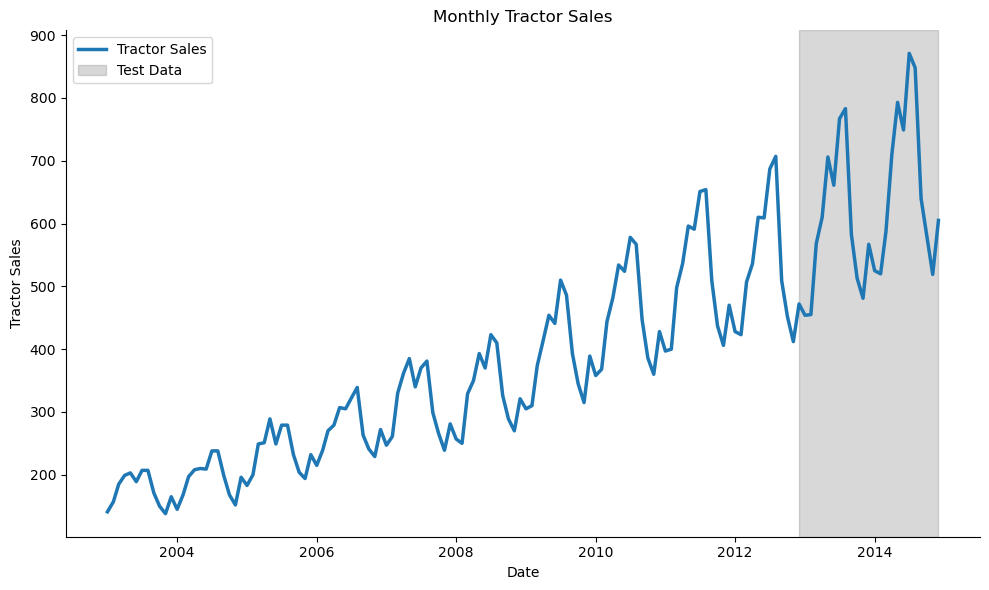

In [198]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['TractorSales'], label='Tractor Sales')

# Highlight the period corresponding to the test data
plt.axvspan(train.index[-1], df.index[-1], color='gray', alpha=0.3, label='Test Data')

# Add labels, title, and show legend
plt.xlabel('Date')
plt.ylabel('Tractor Sales')
plt.title('Monthly Tractor Sales')
plt.legend()

plt.tight_layout()
plt.show()

## Identify Order of ARIMA Model

### ACF and PACF Plots


In [199]:
# ACF and PACF function to plot both Autocorrelation and Partial Autocorrelation
def ACF_and_PACF(data):
    # Create a figure with a specific size (12x9 inches)
    fig = plt.figure(figsize=(12,9))

    # Add subplot for ACF (Autocorrelation Function)
    ax1 = fig.add_subplot(211)  # The '211' means 2 rows, 1 column, and 1st subplot.
    fig = plot_acf(data, lags=40, ax=ax1)  # Plot the ACF with 40 lags (number of time lags to display).

    # Add subplot for PACF (Partial Autocorrelation Function)
    ax2 = fig.add_subplot(212)  # The '212' means 2 rows, 1 column, and 2nd subplot.
    fig = plot_pacf(data, lags=40, ax=ax2)  # Plot the PACF with 40 lags (number of time lags to display).



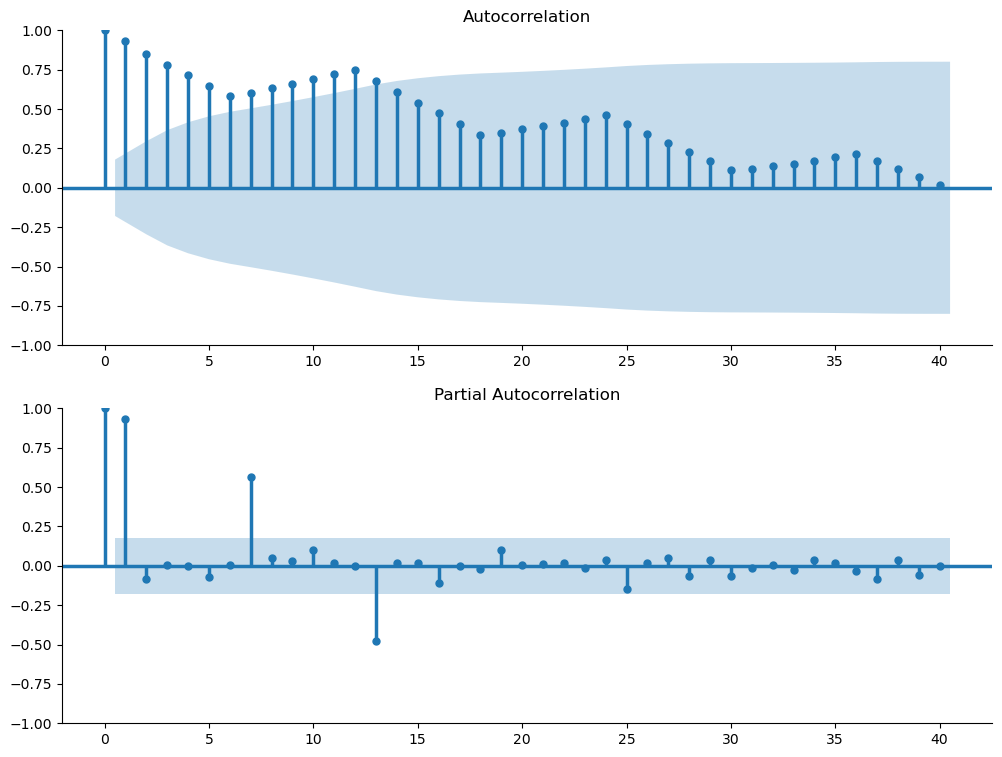

In [200]:
# Call the ACF_and_PACF function for the transformed train data
ACF_and_PACF(train_data)

Here it  indicates that the series follows a complex ARMA process that isn't just seasonal but rather involves intricate autocorrelations that don't decay as quickly as in simpler ARMA models.We need to come up with Model Selection Methods to identify order- p,q and P,Q.m is the number of periods in a season (here 12 for monthly data with yearly seasonality).

Since, there are enough spikes in the plots outside the confidence interval we can conclude that the residuals are not random. This implies that there is information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales.

## Best Order Selection

### Grid Search Method

In [201]:

from typing import List, Tuple, Union
import pandas as pd
from tqdm import tqdm  # Use tqdm for progress bar outside of a notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: List[Tuple[int, int, int, int]], d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    
    # Use tqdm for progress bar
    for order in tqdm(order_list, desc="Optimizing SARIMA models"):
        try:
            # Fit SARIMA model
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s)
            ).fit(disp=False)
        except Exception as e:
            print(f"Model {order} failed with error: {e}")
            continue
        
        # Collect AIC for the model
        aic = model.aic
        results.append([order, aic])
        
    # If no valid models were found
    if not results:
        print("No valid models were found.")
        return pd.DataFrame()
    
    # Create a DataFrame with results
    result_df = pd.DataFrame(results, columns=['(p, q, P, Q)', 'AIC'])
    
    # Sort in ascending order based on AIC
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [202]:
from itertools import product
import pandas as pd

# Define the parameter ranges
p_range = range(0, 3, 1)
q_range = range(0, 3, 1)
P_range = range(0, 3, 1)
Q_range = range(0, 3, 1)

# Differencing values
d = 1  # Non-seasonal differencing
D = 1  # seasonal differencing
s = 12  # 12 for monthly data with yearly seasonality)

# Generate ARIMA order combinations
ARIMA_order_list = list(product(p_range, q_range, P_range, Q_range))
print(ARIMA_order_list)

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 1, 2), (0, 1, 2, 0), (0, 1, 2, 1), (0, 1, 2, 2), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 0, 2), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 1, 2), (0, 2, 2, 0), (0, 2, 2, 1), (0, 2, 2, 2), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 2), (1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 1, 2), (1, 0, 2, 0), (1, 0, 2, 1), (1, 0, 2, 2), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 0, 2), (1, 1, 1, 0), (1, 1, 1, 1), (1, 1, 1, 2), (1, 1, 2, 0), (1, 1, 2, 1), (1, 1, 2, 2), (1, 2, 0, 0), (1, 2, 0, 1), (1, 2, 0, 2), (1, 2, 1, 0), (1, 2, 1, 1), (1, 2, 1, 2), (1, 2, 2, 0), (1, 2, 2, 1), (1, 2, 2, 2), (2, 0, 0, 0), (2, 0, 0, 1), (2, 0, 0, 2), (2, 0, 1, 0), (2, 0, 1, 1), (2, 0, 1, 2), (2, 0, 2, 0), (2, 0, 2, 1), (2, 0, 2, 2), (2, 1, 0, 0), (2, 1, 0, 1), (2, 1, 0, 2), (2, 1, 1, 0), (2, 1, 1, 1), (2, 1, 1, 2), (2, 1, 2, 0), (2, 1, 2, 1), (2, 1

In [203]:
# Call the optimize_SARIMA function
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)

# Display results
ARIMA_result_df

Optimizing SARIMA models: 100%|██████████| 81/81 [01:14<00:00,  1.09it/s]


,"(p, q, P, Q)",AIC
0,"(1, 0, 1, 2)",879.462544
1,"(1, 0, 2, 1)",879.556729
2,"(0, 1, 1, 2)",879.780884
3,"(2, 1, 2, 1)",879.785346
4,"(0, 1, 2, 1)",879.959348
...,...,...
76,"(2, 1, 0, 1)",890.856439
77,"(0, 0, 2, 0)",891.010619
78,"(1, 2, 1, 1)",891.071286
79,"(2, 1, 1, 1)",891.134741


(p, d,q, P,D, Q)	 using grid search--> (1, 1,0, 1,1, 2)

## pmdarima Method

In [204]:
from pmdarima import auto_arima

# # Fit the SARIMA model using pmdarima's auto_arima function with limited search space
model = auto_arima(
    train,
    d=d,
    D=D,
    seasonal=True,
    m=s,  # Periodicity of the seasonality (e.g., 12 for monthly data with yearly seasonality)
    p=p_range,  # List of possible p values
    q=q_range,  # List of possible q values
    P=P_range,  # List of possible P values
    Q=Q_range,  # List of possible Q values
    stepwise=True,  # Stepwise optimization for hyperparameter selection
    trace=True,  # Print progress during the optimization process
    error_action='ignore',  # Ignore any errors during model fitting
    suppress_warnings=True  # Suppress warnings
)

# Get the best model and its parameters
best_order = model.order  # (p, d, q)
best_seasonal_order = model.seasonal_order  # (P, D, Q, s)
best_aic = model.aic()

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    '(p, q, P, Q)': [best_order + best_seasonal_order[:3]],
    'AIC': [best_aic]
})

result_df


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=889.824, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=887.013, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=887.472, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=885.709, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=887.211, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=887.449, Time=0.27 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=887.615, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=887.380, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=885.962, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=889.321, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=887.709, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.357 seconds


,"(p, q, P, Q)",AIC
0,"(1, 1, 0, 0, 1, 0)",885.709143


using pmdarima -(p, d,q, P,D, Q) -	(1, 1, 0, 0, 1, 0)

# Fit Data on  train date(In Sample Data) using the best fit SARIMA model (1,1, 0, 1,1, 2)[12]

- In-sample prediction refers to making predictions on the same data that was used to train the model. This is important to see how well the model fits the historical data and helps detect potential issues like overfitting or underfitting.
- Here we are using original data with only box cox transformation
- By using the model to predict on the training data, you can visually compare the predictions to the actual observed values.

In [205]:
model = SARIMAX(
                train_data, 
                order=(1, 1,0 ),
                seasonal_order=(1,1,2,12)
            ).fit(disp=False)


## Model Diagnostic

Evaluate the model fit to ensure that it is appropriate for the data.

## Model Summary 
This provides a detailed summary of the fitted SARIMA model, including:

- Coefficients (coef): The estimated values for the AR, MA, and seasonal components of the model.
- Standard errors of the coefficients (std err): Used to assess the precision of the coefficient estimates.
- p-values (P>|z|): Tests the hypothesis that the coefficients are zero (null hypothesis). A small p-value (<0.05) indicates that the coefficient is statistically significant.
- AIC/BIC: These are model selection criteria used to compare different models. Lower values indicate better models.
- Log-Likelihood: A measure of model fit (used in AIC/BIC calculation).
- Residual statistics: The residual standard deviation (sigma2), which gives an idea of the overall variance of the residuals.

In [206]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                 115.007
Date:                                 Sat, 15 Feb 2025   AIC                           -220.014
Time:                                         12:45:36   BIC                           -206.650
Sample:                                     01-01-2003   HQIC                          -214.596
                                          - 12-01-2012                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3248      0.079     -4.132      0.000      -0.479      -0.171
ar.S.L12      -0.9940      0.556     -1.789      0.074      -2.083       0.095
ma.S.L12       0.5112      1.187      0.431      0.667      -1.814       2.837
ma.S.L24      -0.4520      0.638     -0.708      0.479      -1.703       0.799
sigma2         0.0065      0.004      1.624      0.104      -0.001       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.77
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.42   Skew:                             0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Plot Diagnostic
This plots several diagnostic tests on the residuals:

- Residuals vs Fitted Values: This plot helps you check for patterns in the residuals. Ideally, residuals should be randomly distributed around 0 (no patterns).
- Histogram of Residuals: Helps check if the residuals are normally distributed. Ideally, it should look like a bell curve.
- Q-Q Plot: Compares the residuals to a normal distribution. If the points closely follow the line, it indicates the residuals are approximately normally distributed.
- ACF of Residuals: The autocorrelation function of residuals. Ideally, there should be no significant autocorrelations (i.e., the autocorrelation should be close to 0 at all lags), indicating that the model has captured all dependencies in the data.
- Ljung-Box Test: This is included in the plot_diagnostics() as well. It checks for autocorrelation in the residuals. A p-value greater than 0.05 suggests that there is no significant autocorrelation, meaning the residuals are white noise.

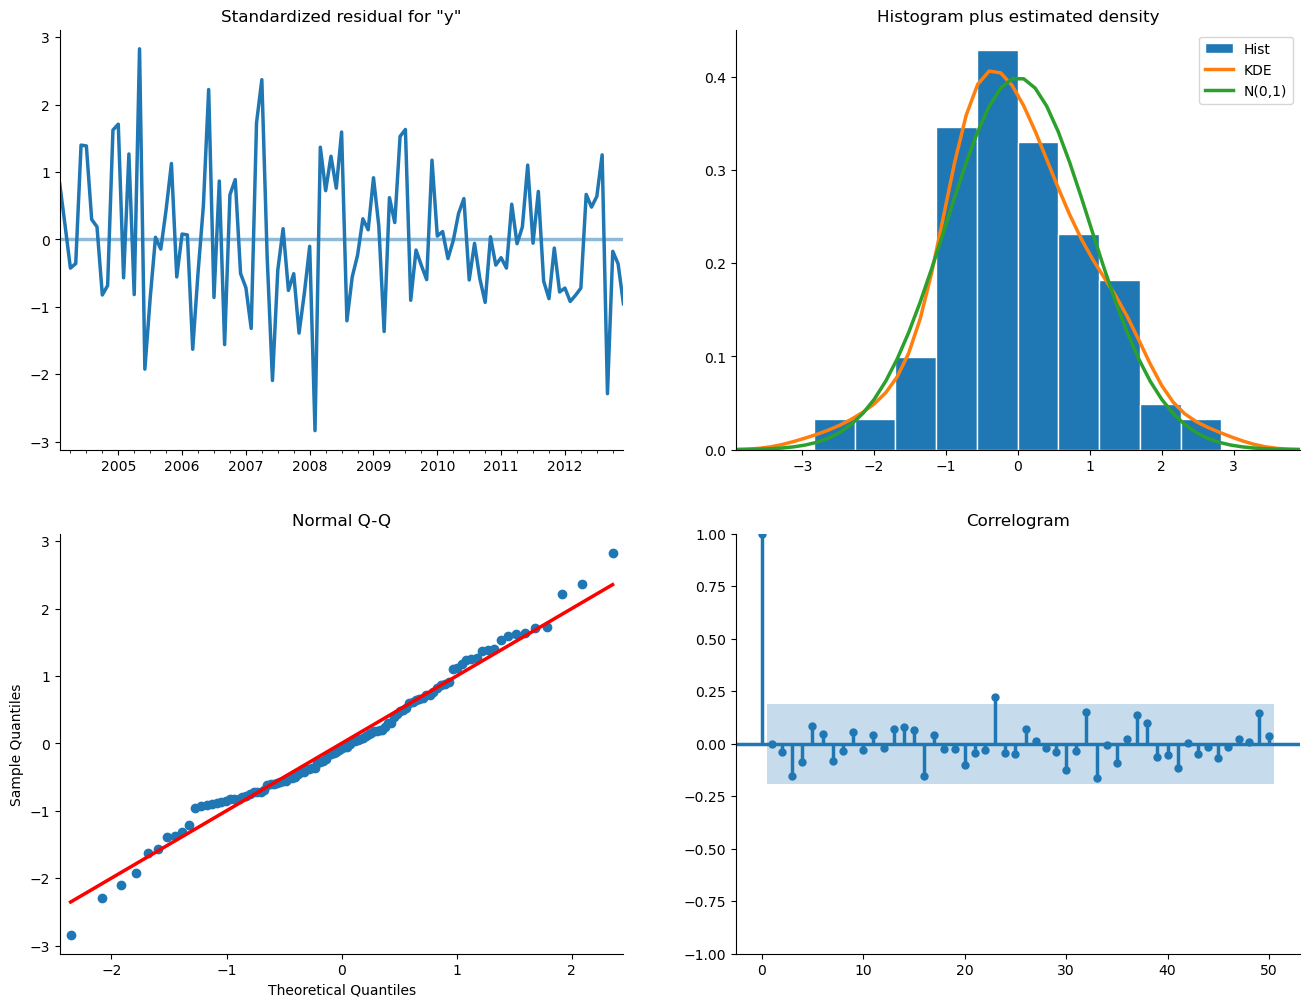

In [207]:
model.plot_diagnostics(lags=50, figsize=(16,12))
plt.show()

## Performance Evaluation On Test data



In [208]:
forecast_test = model.get_prediction(start=len(train), end=len(train)+len(test)-1,dynamic=False)


In [209]:
forecast_mean_test=forecast_test.predicted_mean.to_frame()

# Manually assign test index
forecast_mean_test.index = test.index  # Ensure it matches the test set
forecast_mean_test

,predicted_mean
Date,
2013-01-01,9.394777
2013-02-01,9.387686
2013-03-01,9.838187
2013-04-01,9.995174
2013-05-01,10.267269
2013-06-01,10.219262
2013-07-01,10.484931
2013-08-01,10.509005
2013-09-01,9.847467


In [210]:
confidence_intervals_test=forecast_test.conf_int()


confidence_intervals_test.index = test.index  # Ensure it matches the test set
confidence_intervals_test

,lower y,upper y
Date,,
2013-01-01,9.235882,9.553672
2013-02-01,9.195995,9.579376
2013-03-01,9.609894,10.066479
2013-04-01,9.737939,10.252409
2013-05-01,9.983290,10.551249
2013-06-01,9.911072,10.527452
2013-07-01,10.154231,10.815630
2013-08-01,10.157254,10.860757
2013-09-01,9.475848,10.219086


In [211]:
# Apply inverse Box-Cox transformation to in-sample predictions
inversed_forecast_testdata = inverse_boxcox(forecast_mean_test, lambda_value)

In [212]:
inversed_forecast_testdata

,predicted_mean
Date,
2013-01-01,439.346148
2013-02-01,437.967186
2013-03-01,533.403462
2013-04-01,570.647143
2013-05-01,640.550658
2013-06-01,627.704217
2013-07-01,701.695286
2013-08-01,708.758879
2013-09-01,535.544953


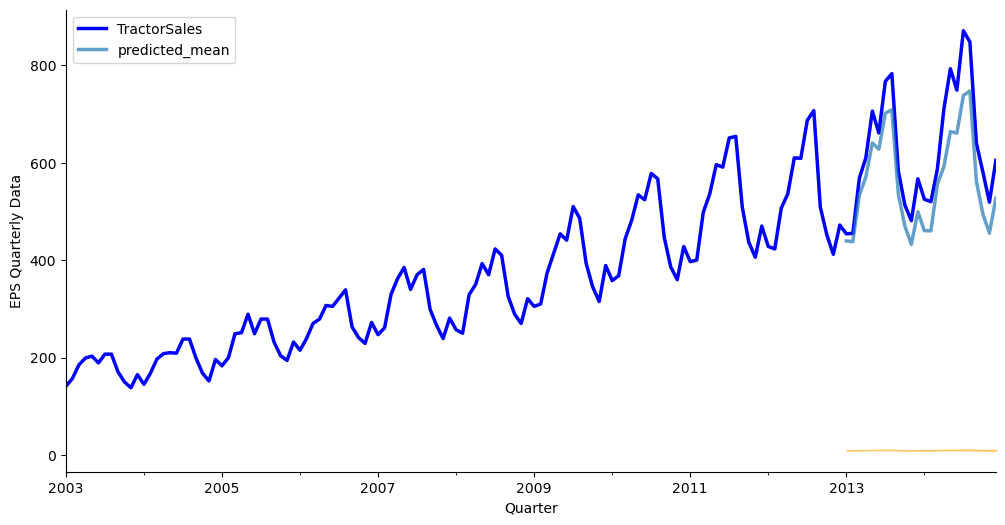

In [213]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# 1️⃣ Plot the full original series
df.plot(ax=ax, label="Original Data", color="blue")


inversed_forecast_testdata.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)
ax.fill_between(confidence_intervals_test.index, confidence_intervals_test.iloc[:, 0], confidence_intervals_test.iloc[:, 1], color='orange', alpha=.5)

ax.set_xlabel('Quarter')
ax.set_ylabel('EPS Quarterly Data')
plt.legend(loc='best')
plt.show()

In [214]:
# Calculate test error
mae_os_test = mean_absolute_error(test['TractorSales'], inversed_forecast_testdata)
print(f"Test Data (Dynamic) MAE: {mae_os_test:.3f}")

Test Data (Dynamic) MAE: 65.886


In [215]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate error metrics
mae = mean_absolute_error(test['TractorSales'], inversed_forecast_testdata)
mse = mean_squared_error(test['TractorSales'], inversed_forecast_testdata)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 65.88601225666179
Mean Squared Error (MSE): 5336.550805884776
Root Mean Squared Error (RMSE): 73.0516995413849


## Refine SARIMA Model by optimizing parameters

- Different Transformation
- Different Orders

# Forecasting Future Data

## Case - Forecasting Data of next Month(Short Term)

In [216]:
# one step ahead forecast - uses actual data
forecast_nextmonth = model.get_prediction(start=len(df), dynamic=False)
forecast_mean_nm=forecast_nextmonth.predicted_mean.to_frame()
forecast_mean_nm


,0
2015-01-01,9.639228


In [217]:
# Apply inverse Box-Cox transformation to forecasted values
forecast_nm = inverse_boxcox(forecast_mean_nm, lambda_value)

In [218]:
print(f"predicted sale of next month is {forecast_nm[0].values}")

predicted sale of next month is [489.24138112]


## Case - Forecasting Data of next 24 Months(Long Term) - Static Forecast

Train once, forecast multiple steps ahead, no updates.Forecasting 12 months ahead in one step, ignoring future actual sales

In [219]:
len(test)

24

In [225]:
forecast_lt=model.forecast(steps=48)

In [226]:
forecast_lt

2013-01-01     9.394777
2013-02-01     9.387686
2013-03-01     9.838187
2013-04-01     9.995174
2013-05-01    10.267269
2013-06-01    10.219262
2013-07-01    10.484931
2013-08-01    10.509005
2013-09-01     9.847467
2013-10-01     9.549145
2013-11-01     9.358092
2013-12-01     9.686057
2014-01-01     9.501209
2014-02-01     9.499494
2014-03-01     9.933215
2014-04-01    10.080744
2014-05-01    10.352573
2014-06-01    10.340961
2014-07-01    10.606600
2014-08-01    10.636645
2014-09-01     9.959462
2014-10-01     9.663655
2014-11-01     9.476212
2014-12-01     9.810864
2015-01-01     9.639228
2015-02-01     9.635084
2015-03-01    10.084537
2015-04-01    10.241775
2015-05-01    10.513768
2015-06-01    10.466013
2015-07-01    10.731671
2015-08-01    10.755785
2015-09-01    10.094151
2015-10-01     9.795845
2015-11-01     9.604813
2015-12-01     9.932818
2016-01-01     9.748050
2016-02-01     9.746321
2016-03-01    10.180136
2016-04-01    10.327724
2016-05-01    10.599554
2016-06-01    10

In [227]:
# inverse box cox
# Apply inverse Box-Cox transformation to forecasted values
forecast_lt_inverse= inverse_boxcox(forecast_lt, lambda_value)

In [228]:

last_train_index = train.index[-1]  # Last date in training data

# Generate future timestamps for 17 quarters ahead
future_dates = pd.date_range(start=last_train_index, periods=48, freq='M')[1:]  # Exclude last train dat

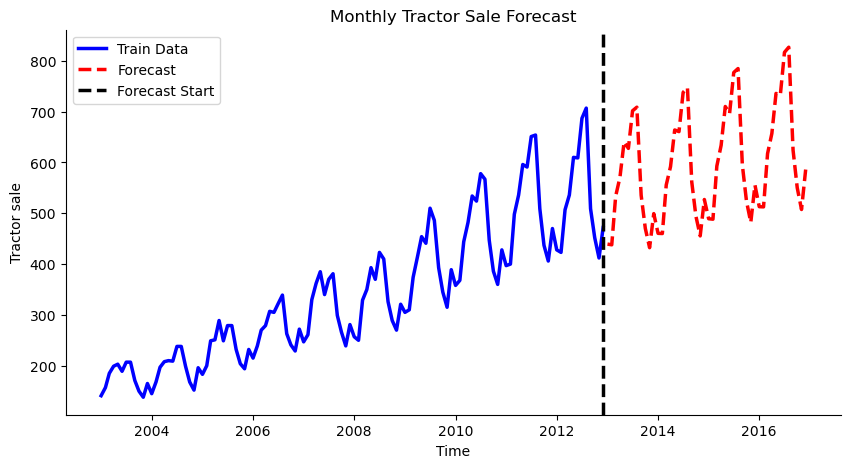

In [230]:

#Plot results
plt.figure(figsize=(10, 5))
plt.plot(train, label="Train Data", color='blue')

plt.plot(forecast_lt_inverse, label="Forecast", color='red', linestyle='dashed')
plt.axvline(x=last_train_index, color='black', linestyle='--', label="Forecast Start")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Tractor sale")
plt.title("Monthly Tractor Sale Forecast")
plt.show()


In real life since you receive new data every month, you should adopt a rolling forecasting approach, where you:

✅ Automate the process for continuous forecasting.

✅ Train the model on available data.

✅ Forecast the next month.

✅ Compare the forecast with actual data when it arrives.

✅ Update the model with the new data and repeat.

## 🚀  Rolling forecasting
Train, predict 1 step ahead, update with actual data, repeat.Predicting next month’s sales, updating with real data, and continuing.
is a dynamic process where the model continuously learns from new monthly sales data.

Instead of making a one-time forecast for the entire year, we update the model every month.
This ensures our forecasts are up-to-date and accurate.
